In [2]:
# 셀 1: 기본 import + 경로 설정

from pathlib import Path
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error

DATA_DIR = Path("../app/data_pipeline")

fea_path = DATA_DIR / "features_all.csv"
model_path = DATA_DIR / "lightgbm_model.pkl"
features_json = DATA_DIR / "lightgbm_features.json"

print(f"features_all.csv exists: {fea_path.exists()}")
print(f"model exists: {model_path.exists()}")
print(f"features json exists: {features_json.exists()}")


features_all.csv exists: True
model exists: True
features json exists: True


In [3]:
# 셀 2: features_all + 모델 + feature 목록 로드

import joblib

fea = pd.read_csv(fea_path, parse_dates=["target_date"])
print("features_all shape:", fea.shape)
print("target_date range:", fea["target_date"].min(), "→", fea["target_date"].max())
print("split value_counts:")
print(fea["split"].value_counts())

model = joblib.load(model_path)

with open(features_json, "r", encoding="utf-8") as f:
    features_used = json.load(f)

print("\nfeatures_used (len={}):".format(len(features_used)))
print(features_used)

X = fea[features_used]
y = fea["y"]
split = fea["split"]

# 전체 데이터에 대해 예측
y_pred = model.predict(X)

# 분석용 데이터프레임 구성
df_pred = fea[["warehouse_id", "store_id", "sku_id", "region", "target_date", "split", "y"]].copy()
df_pred["y_pred"] = y_pred

df_pred.head()


features_all shape: (300300, 48)
target_date range: 2023-02-27 00:00:00 → 2031-12-29 00:00:00
split value_counts:
split
train    266500
test      33800
Name: count, dtype: int64

features_used (len=37):
['lag_1', 'lag_2', 'lag_4', 'lag_8', 'lag_12', 'ma_4', 'ma_8', 'ma_12', 'std_4', 'std_12', 'trend_1', 'trend_4', 'promo_flag_prev', 'year', 'weekofyear', 'month', 'sin_week', 'cos_week', 'avg_temp_c', 'cdd', 'hdd', 'precip_mm', 'heat_wave', 'cold_wave', 'himart_sales_krw', 'himart_sales_index', 'holiday_index', 'marketing_score', 'seasonal_peak', 'back_to_school', 'avg_temp_c_ma4', 'cdd_ma4', 'hdd_ma4', 'precip_mm_ma4', 'himart_sales_index_ma4', 'holiday_index_ma4', 'marketing_score_ma4']


,warehouse_id,store_id,sku_id,region,target_date,split,y,y_pred
0,1,1,AC-CAR-16P-2024,본사창고,2023-02-27,train,0.0,1401.538828
1,1,1,AC-CAR-16P-2024,본사창고,2023-03-06,train,0.0,0.101216
2,1,1,AC-CAR-16P-2024,본사창고,2023-03-13,train,0.0,0.105361
3,1,1,AC-CAR-16P-2024,본사창고,2023-03-20,train,0.0,0.105355
4,1,1,AC-CAR-16P-2024,본사창고,2023-03-27,train,0.0,0.001259


In [4]:
# 셀 3: MAE / MAPE / SMAPE 함수 정의 + train/test 비교

def mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    denom = np.where(y_true == 0, 1, y_true)
    return np.mean(np.abs(y_true - y_pred) / np.abs(denom)) * 100

def smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2
    denom = np.where(denom == 0, 1, denom)
    return np.mean(np.abs(y_true - y_pred) / denom) * 100

def print_metrics(name, y_true, y_hat):
    mae = mean_absolute_error(y_true, y_hat)
    mape_val = mape(y_true, y_hat)
    smape_val = smape(y_true, y_hat)
    print(f"[{name}] MAE={mae:,.3f} | MAPE={mape_val:,.2f}% | SMAPE={smape_val:,.2f}%")

train_mask = df_pred["split"] == "train"
test_mask  = df_pred["split"] == "test"

print_metrics("TRAIN", df_pred.loc[train_mask, "y"], df_pred.loc[train_mask, "y_pred"])
print_metrics("TEST ", df_pred.loc[test_mask,  "y"], df_pred.loc[test_mask,  "y_pred"])


[TRAIN] MAE=18.329 | MAPE=199.68% | SMAPE=100.34%
[TEST ] MAE=392.956 | MAPE=30.80% | SMAPE=6.04%


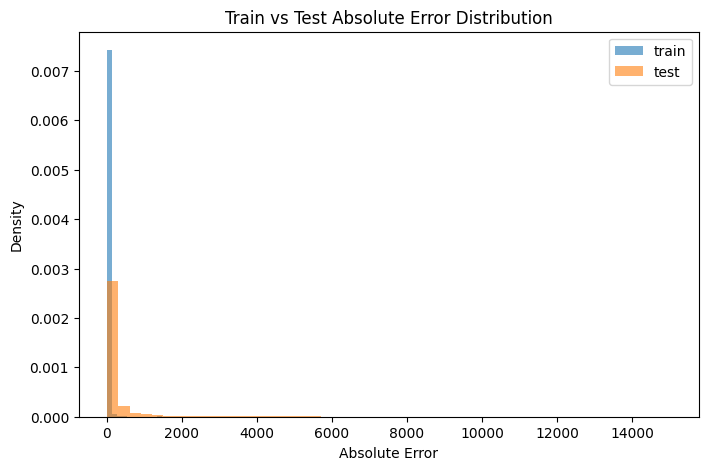

In [5]:
# 셀 4: train vs test 절대오차 분포 비교

df_pred["abs_err"] = (df_pred["y"] - df_pred["y_pred"]).abs()

train_err = df_pred.loc[train_mask, "abs_err"]
test_err  = df_pred.loc[test_mask,  "abs_err"]

plt.figure(figsize=(8, 5))
plt.hist(train_err, bins=50, alpha=0.6, label="train", density=True)
plt.hist(test_err,  bins=50, alpha=0.6, label="test",  density=True)
plt.xlabel("Absolute Error")
plt.ylabel("Density")
plt.title("Train vs Test Absolute Error Distribution")
plt.legend()
plt.show()


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_43976\1915150166.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(sku_mae)


pivot head:
split                        test      train
sku_id                                      
AC-CAR-16P-2024         99.707196  15.380995
AC-LG-STAND-18P-2024  1217.296530  30.584364
AC-LG-WS-6P-2024        32.499735  13.572069
AC-SAM-WF-18P-2024     605.919300  19.983254
AIR-LG-PURI-58-2024   1772.190659  33.083316


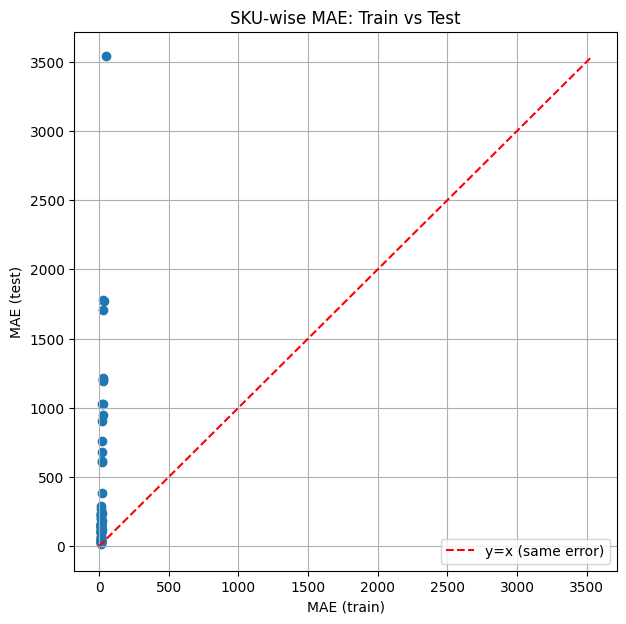

In [6]:
# 셀 5: SKU별 train/test MAE 비교

def sku_mae(group):
    return mean_absolute_error(group["y"], group["y_pred"])

sku_mae_df = (
    df_pred
      .groupby(["sku_id", "split"])
      .apply(sku_mae)
      .reset_index(name="mae")
)

pivot = sku_mae_df.pivot(index="sku_id", columns="split", values="mae")

print("pivot head:")
print(pivot.head())

plt.figure(figsize=(7, 7))
plt.scatter(pivot["train"], pivot["test"])
max_val = max(pivot["train"].max(), pivot["test"].max())
plt.plot([0, max_val], [0, max_val], "r--", label="y=x (same error)")
plt.xlabel("MAE (train)")
plt.ylabel("MAE (test)")
plt.title("SKU-wise MAE: Train vs Test")
plt.legend()
plt.grid(True)
plt.show()


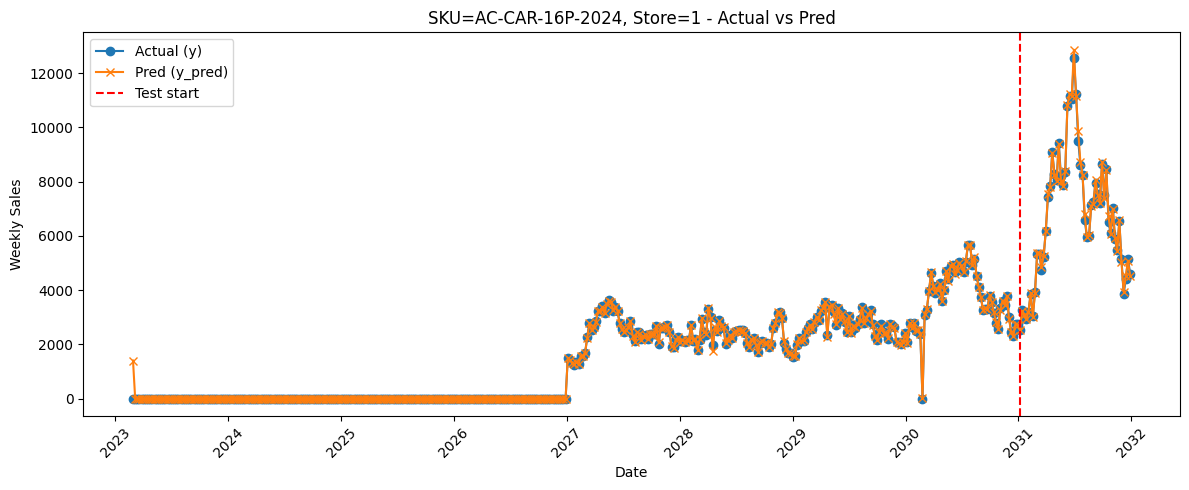

In [7]:
# 셀 6: 특정 SKU + 매장 타임시리즈 actual vs pred 그리는 함수

def plot_sku_timeseries(sku_id, store_id=1):
    sub = df_pred[(df_pred["sku_id"] == sku_id) & (df_pred["store_id"] == store_id)].copy()
    if sub.empty:
        print(f"No data for sku_id={sku_id}, store_id={store_id}")
        return
    
    sub = sub.sort_values("target_date")
    
    # test 구간 시작 시점
    test_start = sub.loc[sub["split"] == "test", "target_date"].min()
    
    plt.figure(figsize=(12, 5))
    plt.plot(sub["target_date"], sub["y"],      marker="o", label="Actual (y)")
    plt.plot(sub["target_date"], sub["y_pred"], marker="x", label="Pred (y_pred)")
    
    if pd.notna(test_start):
        plt.axvline(test_start, color="red", linestyle="--", label="Test start")
    
    plt.title(f"SKU={sku_id}, Store={store_id} - Actual vs Pred")
    plt.xlabel("Date")
    plt.ylabel("Weekly Sales")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 예시 호출 (실제 존재하는 sku_id 넣어보기)
plot_sku_timeseries("AC-CAR-16P-2024", store_id=1)


In [8]:
# 셀 7: "train은 엄청 좋고, test는 엄청 안 좋은" SKU 찾기

pivot = pivot.dropna()

pivot["gap"] = pivot["test"] - pivot["train"]  # 양수면 test가 더 나쁨

# gap이 큰 상위 10개 SKU
sus = pivot.sort_values("gap", ascending=False).head(10)
sus


split,test,train,gap
sku_id,,,
MIX-BRV-STAND-5L-2024,3540.013275,51.440827,3488.572449
MW-SAM-30L-2024,1777.194803,31.248975,1745.945828
AIR-LG-PURI-58-2024,1772.190659,33.083316,1739.107343
WM-LG-TOP-21K-2024,1707.917852,25.069881,1682.847971
AC-LG-STAND-18P-2024,1217.296530,30.584364,1186.712166
FR-SAM-4D-820L-2024,1199.228719,29.667877,1169.560843
DRY-SAM-GRN-20K-2024,1195.073638,29.469319,1165.604319
DRY-LG-TROM-19K-2024,1025.419225,22.773001,1002.646224
MW-LG-25L-2024,1024.480680,28.818656,995.662023
